In [39]:
import pandas as pd

all = pd.read_csv('all_lat.csv', index_col=False)
# 移除土地與車位
all = all [all ['交易標的'] != '土地']
all = all[all['交易標的'] != '車位']
all = all[all['交易年月日']>= 1060101]

c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
NA_columns = all.columns[all.isna().any()].tolist()
all[NA_columns].isnull().sum()

都市土地使用分區      2647
非都市土地使用分區    47955
非都市土地使用編定    47955
移轉層次           117
總樓層數            87
主要用途            78
主要建材            69
建築完成年月        1814
單價元/平方公尺       230
車位類別         25475
備註           30207
lat          13596
lng          13596
dtype: int64

> https://drive.google.com/open?id=1raKuQ5sQvNMg-N0riEuDo9IpavoTjXCaSZLSLntE4Eo

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
country = le.fit_transform(all['鄉鎮市區'])
country

array([11, 11,  6, ..., 11, 11, 11])

In [119]:
# 補齊沒車位的
all['車位類別'] = all['車位類別'].fillna('無')
all['都市土地使用分區'] = all['都市土地使用分區'].fillna('非')
all['主要建材'] = all['主要建材'].fillna('others')
all['主要用途'] = all['主要用途'].fillna('others')

In [120]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
feature = ohe.fit_transform(all[['鄉鎮市區', '都市土地使用分區', '車位類別', '建物現況格局-隔間', '有無管理組織', '主要建材','主要用途']]).toarray()
feature = pd.DataFrame(feature)
feature.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
target = all['總價元']
num_feature = all[['建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '建物移轉總面積平方公尺', 'lat', 'lng']].copy()

In [122]:
# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_feature['建物移轉總面積平方公尺'] = scaler.fit_transform(num_feature[['建物移轉總面積平方公尺']])
num_feature = num_feature.reset_index().drop('index', axis=1)

In [ ]:
# 移轉樓層比例 

> https://stackoverflow.com/questions/50368145/pandas-concat-increases-number-of-rows

In [123]:
features = pd.concat([num_feature, feature], axis=1)
print(num_feature.shape)
print(feature.shape)
print(features.shape)

(50401, 6)
(50401, 72)
(50401, 78)


In [124]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(128, input_dim=features.columns.size, activation='relu', name='dense1'))
model.add(Dense(64, name='dense2', kernel_initializer='normal', activation='relu'))
model.add(Dense(32, name='dense3', kernel_initializer='normal', activation='relu'))
model.add(Dense(64, name='dense4', kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear', name='output_layer'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 128)               10112     
_________________________________________________________________
dense2 (Dense)               (None, 64)                8256      
_________________________________________________________________
dense3 (Dense)               (None, 32)                2080      
_________________________________________________________________
dense4 (Dense)               (None, 64)                2112      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 22,625
Trainable params: 22,625
Non-trainable params: 0
_________________________________________________________________


> https://zhuanlan.zhihu.com/p/34667893

In [125]:
from keras import backend as K
def mean_absolute_percentage_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),K.epsilon(),None))
    return 100. * K.mean(diff, axis=-1)

model.compile(loss=mean_absolute_percentage_error, optimizer='adam', metrics=['accuracy'])
train_history = model.fit(x=features, y=target, validation_split=0.2, epochs=100, batch_size=300, verbose=0)

In [104]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc], color='green')
    plt.plot(train_history.history[test_acc], color='cyan')
    plt.title('Train History')
    plt.ylabel(train_acc)
    plt.xlabel('Epoch')
    plt.legend(['deep_train', 'deep_test', 'shallow_train', 'shallow_test'], loc='upper left')
    plt.show()

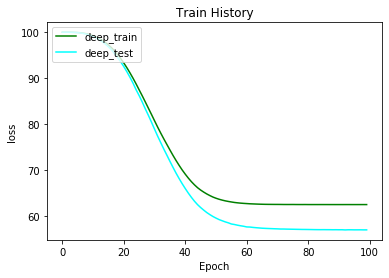

In [126]:
show_train_history('loss', 'val_loss')